# CIFAR 10 v3

### Extract CIFAR-10 training data

Remove CIFAR-10 and train directories if they exist. Open the train.7z archive and extract its contents into the current directory. Rename the extracted train folder to CIFAR-10.

In [1]:
from pathlib import Path
import py7zr, shutil

shutil.rmtree("CIFAR-10", ignore_errors=True)
shutil.rmtree("train", ignore_errors=True)

archive = "train.7z"

with py7zr.SevenZipFile(archive, mode="r") as z:
    z.extractall(path=".")

Path("train").rename("CIFAR-10")

print(f"extracted {archive} to CIFAR-10/")

extracted train.7z to CIFAR-10/


### Calculate the mean and standard deviation

Load the training CSV file. Walk through each CIFAR-10 image by id. Open as RGB, convert to float in the 0 to 1 range, and accumulate per-channel sums and squared sums across all pixels. Compute the per-channel mean and standard deviation from those totals. Clip numerical noise, round to four decimals, cast to tuples, and print them.

The mean and std values are needed for normalization so inputs are centered and comparably scaled, which stabilizes optimization and speeds convergence.

In [2]:
import pandas as pd
from pathlib import Path
from PIL import Image
import numpy as np

df = pd.read_csv("trainLabels.csv")
root_path = Path("CIFAR-10")

sum_ = np.zeros(3, dtype=np.float64)
sum_sq = np.zeros(3, dtype=np.float64)
n = 0

for img_id in df["id"]:
    x = (
        np.asarray(
            Image.open(root_path / f"{img_id}.png").convert("RGB"), dtype=np.float32
        )
        / 255.0
    )

    sum_ += x.sum(axis=(0, 1))
    sum_sq += (x * x).sum(axis=(0, 1))
    n += x.shape[0] * x.shape[1]

mean = sum_ / n
var = (sum_sq / n) - mean * mean
std = np.sqrt(np.clip(var, 0, None))

data_mean = tuple(np.round(mean, 4).tolist())
data_std = tuple(np.round(std, 4).tolist())

print("data_mean:", data_mean)
print("data_std: ", data_std)

data_mean: (0.4914, 0.4822, 0.4465)
data_std:  (0.247, 0.2435, 0.2616)


### Split CIFAR-10 data into train and test sets

Read the CIFAR-10 labels. Create an 80/20 stratified split into training and testing so class balance is preserved. Write out two CSVs as train_split.csv and test_split.csv. Print the row counts and show a preview of both DataFrames to confirm the structures.

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("trainLabels.csv")

train_df, test_df = train_test_split(
    df, test_size=0.2, stratify=df["label"], random_state=17
)

train_df.to_csv("train_split.csv", index=False)
test_df.to_csv("test_split.csv", index=False)

print("Training size:", len(train_df))
print("Testing size:", len(test_df))

print("\ntrain_df.head():")
print(train_df.head())
print("\ntest_df.head():")
print(test_df.head())

Training size: 40000
Testing size: 10000

train_df.head():
          id label
32881  32882   cat
43589  43590  bird
35875  35876   cat
37064  37065  ship
35849  35850  bird

test_df.head():
          id  label
10828  10829   frog
18264  18265   deer
14738  14739  horse
12811  12812    cat
16847  16848   ship


### Train model

Load image and label pairs from the CSV files and the CIFAR-10 folder, then build two torchvision pipelines. The training pipeline applies random crop and horizontal flip, converts to tensors, normalizes with the precomputed mean and std from above, and uses random erasing. The test pipeline only converts and normalizes. Define a small network with three convolution and batch normalization layers, max pooling after each stage, a dropout layer, and a final linear layer that outputs ten class logits. Wrap the dataset in PyTorch DataLoaders for training and testing. Create the model, set up cross-entropy loss, and initialize an Adam optimizer with weight decay. Train in a loop that runs up to two hundred epochs, using a cosine annealing learning rate schedule, tracking loss and accuracy for both splits each epoch. Save a checkpoint file to best.pt whenever test accuracy improves. Apply early stopping after a patience window without improvement, and print the best test accuracy at the end.

In [4]:
import pandas as pd
from pathlib import Path
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import CosineAnnealingLR


CLASSES = {
    "airplane": 0,
    "automobile": 1,
    "bird": 2,
    "cat": 3,
    "deer": 4,
    "dog": 5,
    "frog": 6,
    "horse": 7,
    "ship": 8,
    "truck": 9,
}


class ImageDataset(Dataset):
    def __init__(self, image_dir, csv_file, mean, std, train):
        self.image_dir = Path(image_dir)
        self.df = pd.read_csv(csv_file)

        if train:
            self.tf = transforms.Compose(
                [
                    transforms.RandomCrop(32, padding=4),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize(mean, std),
                    transforms.RandomErasing(p=0.2),
                ]
            )
        else:
            self.tf = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Normalize(mean, std),
                ]
            )

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index]
        img = Image.open(self.image_dir / f"{row['id']}.png").convert("RGB")
        x = self.tf(img)
        y = CLASSES[row["label"]]
        return x, y


class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(128 * 4 * 4, 10)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        x = torch.flatten(x, 1)
        x = self.dropout(x)
        return self.fc(x)


train_data = ImageDataset(
    "CIFAR-10",
    "train_split.csv",
    data_mean,
    data_std,
    True,
)

test_data = ImageDataset(
    "CIFAR-10",
    "test_split.csv",
    data_mean,
    data_std,
    False,
)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True, num_workers=0)
test_loader = DataLoader(test_data, batch_size=256, shuffle=False, num_workers=0)

model = Network()
loss_function = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)


def run_epoch(loader, train_mode=True):
    model.train(train_mode)
    total_loss, correct, count = 0.0, 0, 0

    for images, labels in loader:
        if train_mode:
            optimizer.zero_grad()

        logits = model(images)
        loss = loss_function(logits, labels)

        if train_mode:
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * images.size(0)
        correct += (logits.argmax(1) == labels).sum().item()
        count += labels.size(0)

    return total_loss / count, correct / count


num_epochs = 200
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-5)

patience = 10
best_accuracy = 0.0
no_improvement_count = 0

train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

for epoch in range(1, num_epochs + 1):
    training_loss, training_accuracy = run_epoch(train_loader, True)
    test_loss, test_accuracy = run_epoch(test_loader, False)

    print(
        f"epoch: {epoch:02d}  training_loss: {training_loss:.4f}  training_accuracy: {training_accuracy:.4f}. test_loss: {test_loss:.4f}  test_accuracy: {test_accuracy:.4f}"
    )

    train_losses.append(training_loss)
    train_accuracies.append(training_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    scheduler.step()

    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        no_improvement_count = 0

        torch.save(model.state_dict(), "best.pt")
    else:
        no_improvement_count += 1

        if no_improvement_count >= patience:
            print(f"Early stopping at epoch {epoch:02d}.")
            break

print(f"Best test accuracy: {best_accuracy:.4f}")

epoch: 01  training_loss: 1.5452  training_accuracy: 0.4400. test_loss: 1.2785  test_accuracy: 0.5472
epoch: 02  training_loss: 1.2005  training_accuracy: 0.5702. test_loss: 0.9935  test_accuracy: 0.6531
epoch: 03  training_loss: 1.0830  training_accuracy: 0.6172. test_loss: 1.0597  test_accuracy: 0.6380
epoch: 04  training_loss: 1.0125  training_accuracy: 0.6441. test_loss: 0.9927  test_accuracy: 0.6527
epoch: 05  training_loss: 0.9606  training_accuracy: 0.6614. test_loss: 0.8583  test_accuracy: 0.7011
epoch: 06  training_loss: 0.9038  training_accuracy: 0.6835. test_loss: 0.7718  test_accuracy: 0.7319
epoch: 07  training_loss: 0.8741  training_accuracy: 0.6946. test_loss: 0.7736  test_accuracy: 0.7327
epoch: 08  training_loss: 0.8513  training_accuracy: 0.7043. test_loss: 0.7677  test_accuracy: 0.7408
epoch: 09  training_loss: 0.8224  training_accuracy: 0.7105. test_loss: 0.7143  test_accuracy: 0.7520
epoch: 10  training_loss: 0.7947  training_accuracy: 0.7230. test_loss: 0.7237  te

### Display graphs showing training progress

Create a range from 1 through the number of recorded epochs that occured before early quitting. Draw figures for training and test loss and accuracy over the epoch range. These plots create a visual of convergence, and the effects of experimenting with hyperparamter tuning.

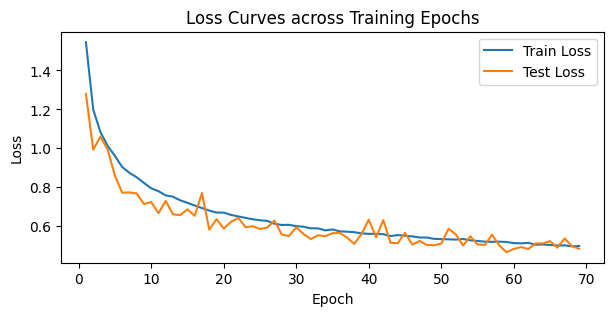

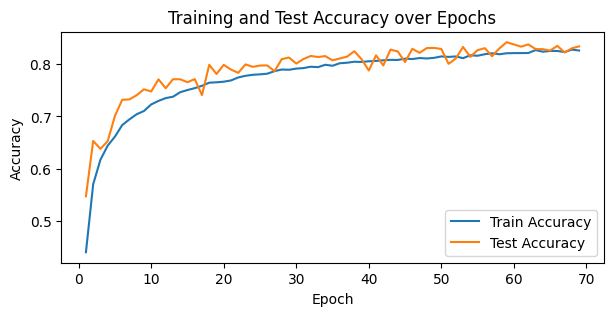

In [5]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(7, 3))
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves across Training Epochs")
plt.legend()
plt.show()

plt.figure(figsize=(7, 3))
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, test_accuracies, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Test Accuracy over Epochs")
plt.legend()
plt.show()

### Model Summary

Instantiate the network and switch it to eval mode so layers like dropout are disabled and batch normalization uses running stats. Call `torchinfo.summary` with a dummy input size of 1×3×32×32 to generate a layer by layer report. Show columns for kernel size, output tensor shape, parameter counts, and whether those params are trainable. Limit the module expansion to depth 3 so the printout stays readable.

In [6]:
from torchinfo import summary

model = Network()
model.eval()

summary(
    model,
    input_size=(1, 3, 32, 32),
    col_names=("kernel_size", "output_size", "num_params", "trainable"),
    depth=3,
)

Layer (type:depth-idx)                   Kernel Shape              Output Shape              Param #                   Trainable
Network                                  --                        [1, 10]                   --                        True
├─Conv2d: 1-1                            [3, 3]                    [1, 32, 32, 32]           896                       True
├─BatchNorm2d: 1-2                       --                        [1, 32, 32, 32]           64                        True
├─MaxPool2d: 1-3                         2                         [1, 32, 16, 16]           --                        --
├─Conv2d: 1-4                            [3, 3]                    [1, 64, 16, 16]           18,496                    True
├─BatchNorm2d: 1-5                       --                        [1, 64, 16, 16]           128                       True
├─MaxPool2d: 1-6                         2                         [1, 64, 8, 8]             --                        --
├─Conv2

#### Calculate confusion matrix:

Load the best checkpoint from the best.pt file and switch the model to evaluation mode. Run the test DataLoader without gradient tracking and take the argmax of the logits to get class predictions. Collect both predictions and true labels across the entire test set. Concatenate everything into flat NumPy arrays and compute a 10×10 confusion matrix with a fixed label order. Map the numeric indices back to class names from the CLASSES dictionary, wrap the matrix in a labeled DataFrame, and print it. Create a row-normalized version by dividing each row by its sum to show per-class rates, then plot it as a heatmap with a colorbar. Add class names on both axes, axis titles, and display the figure.

            airplane  automobile  bird  cat  deer  dog  frog  horse  ship  \
airplane         877           4    13   17     6    0     4     10    49   
automobile        10         922     2    2     0    4     2      3    12   
bird              47           6   771   30    54   39    21     21     8   
cat               18           3    35  668    35  152    25     47     7   
deer              18           0    23   27   854   19    10     45     2   
dog                7           1    27  102    30  780     4     45     1   
frog               8           2    43   42    31   25   833      9     2   
horse             12           0    10   24    23   24     2    904     0   
ship              32           9     5    3     3    1     3      3   927   
truck             25          49     6    7     1    3     2      7    14   

            truck  
airplane       20  
automobile     43  
bird            3  
cat            10  
deer            2  
dog             3  
frog        

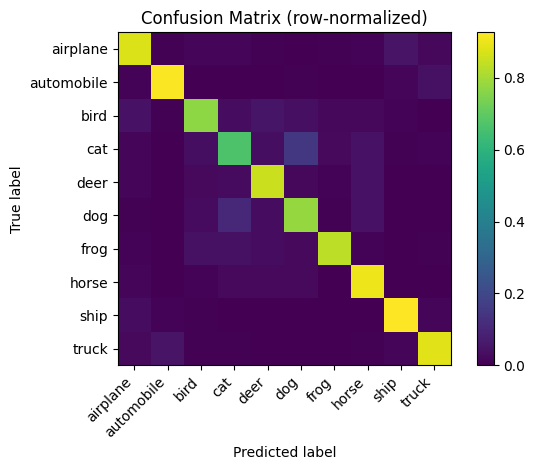

In [7]:
from sklearn.metrics import confusion_matrix

model.load_state_dict(torch.load("best.pt", map_location="cpu"))
model.eval()

all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        logits = model(images)
        preds = logits.argmax(1)
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

y_pred = torch.cat(all_preds).numpy()
y_true = torch.cat(all_labels).numpy()

cm = confusion_matrix(y_true, y_pred, labels=list(range(10)))

idx_to_class = {v: k for k, v in CLASSES.items()}
names = [idx_to_class[i] for i in range(10)]
cm_df = pd.DataFrame(cm, index=names, columns=names)
print(cm_df)

cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

plt.figure()
plt.imshow(cm_norm, interpolation="nearest")
plt.title("Confusion Matrix (row-normalized)")
plt.colorbar()

ticks = np.arange(len(names))
plt.xticks(ticks, names, rotation=45, ha="right")
plt.yticks(ticks, names)
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()